In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep

2025-12-01 21:03:58.018502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 21:03:58.090234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 21:04:23.955908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
###################### PARAMS ##############################

BACKBONE = "resnet18"

BATCH_SIZE = 512
N_EPOCHS = 100 # 1000
N_CPU_WORKERS = 16
BASE_LR = 0.03         # important
WEIGHT_DECAY = 5e-4    # important
MOMENTUM = 0.9
PROJECTOR_HIDDEN_SIZE = 1024
PROJECTOR_OUTPUT_SIZE = 128
CROP_LOW_SCALE = 0.2
GRAYSCALE_PROB = 0.1   # important
PRINT_EVERY_EPOCHS = 5

MODEL_FILENAME = f"path_mnist-{BACKBONE}_wo_rotation-{np.random.randint(10000):04}.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
###################### DATA LOADER #########################

pmnist_train = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())
pmnist_test = PathMNIST(split='test', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())

print("Data loaded.")

# additional rotation
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

transforms_ssl = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        # RandomRightAngleRotation(), # additional rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
        ),
        transforms.RandomGrayscale(p=GRAYSCALE_PROB),
        transforms.ToTensor(), # NB: runtime faster when this line is last
    ]
)

class PairedTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return (self.transform(x), self.transform(x))


paired_ssl_transforms = PairedTransform(transforms_ssl)

pmnist_train_ssl = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=paired_ssl_transforms)

pmnist_loader_ssl = DataLoader(
    pmnist_train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
    pin_memory=True,
)

###################### NETWORK ARCHITECTURE #########################

class ResNetwithProjector(nn.Module):
    def __init__(self, backbone_network):
        super().__init__()

        self.backbone = backbone_network(weights=None)
        self.backbone_output_dim = self.backbone.fc.in_features
        
        self.backbone.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.backbone.maxpool = nn.Identity()
        self.backbone.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(self.backbone_output_dim, PROJECTOR_HIDDEN_SIZE), 
            nn.ReLU(), 
            nn.Linear(PROJECTOR_HIDDEN_SIZE, PROJECTOR_OUTPUT_SIZE),
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return h, z


def infoNCE(features, temperature=0.5):
    x = F.normalize(features)
    cos_xx = x @ x.T / temperature
    cos_xx.fill_diagonal_(float("-inf"))
    
    batch_size = cos_xx.size(0) // 2
    targets = torch.arange(batch_size * 2, dtype=int, device=cos_xx.device)
    targets[:batch_size] += batch_size
    targets[batch_size:] -= batch_size

    return F.cross_entropy(cos_xx, targets)

backbones = {
   "resnet18": resnet18,    # backbone_output_dim = 512
   "resnet34": resnet34,    # backbone_output_dim = 512
   "resnet50": resnet50,    # backbone_output_dim = 2048
}


Data loaded.


# SimCLR

In [19]:
model_resnet18 = ResNetwithProjector(backbones[BACKBONE]).to(device)
model_resnet18_wo_rotation = ResNetwithProjector(backbones[BACKBONE]).to(device)

In [14]:
#summary(model_resnet18, input_size=(3, 28, 28),  device=device.type)

In [15]:
#print(model_resnet18)

In [20]:
model_resnet18.load_state_dict(torch.load('results/model_weights/1146-path_mnist-resnet18.pt', weights_only=True))
model_resnet18_wo_rotation.load_state_dict(torch.load('results/model_weights/7711-path_mnist-resnet18_wo_rotation.pt', weights_only=True))

<All keys matched successfully>

# EqCLR

In [ ]:
model_eq = EqResNet18(N=4).to(device)
model_eq_w_rotation = EqResNet18(N=4).to(device)


In [21]:
model_eq_n8 = EqResNet18(N=8).to(device)

#summary(model_eq, input_size=(3, 28, 28),  device=device.type)
# print(model_eq)

In [ ]:
model_eq.load_state_dict(torch.load('results/model_weights/3957-path_mnist-eqCLR_resnet18_wo_rotation.pt', weights_only=True))
model_eq_w_rotation.load_state_dict(torch.load('results/model_weights/3943-path_mnist-eqCLR_resnet18_with_rotation.pt', weights_only=True))

<All keys matched successfully>

In [22]:
model_eq_n8.load_state_dict(torch.load('results/model_weights/9521-path_mnist-eqCLR_resnet18_wo_rot_N8_weights.pt', weights_only=True))

RuntimeError: Error(s) in loading state_dict for EqResNet18:
	Missing key(s) in state_dict: "layer2.0.downsample.0.filter", "layer2.0.downsample.1.weights", "layer2.0.downsample.1.filter", "layer2.0.downsample.1._basisexpansion.block_expansion_('regular', 'regular').sampled_basis", "layer3.0.downsample.0.filter", "layer3.0.downsample.1.weights", "layer3.0.downsample.1.filter", "layer3.0.downsample.1._basisexpansion.block_expansion_('regular', 'regular').sampled_basis", "layer4.0.downsample.0.filter", "layer4.0.downsample.1.weights", "layer4.0.downsample.1.filter", "layer4.0.downsample.1._basisexpansion.block_expansion_('regular', 'regular').sampled_basis". 
	Unexpected key(s) in state_dict: "layer2.0.downsample.weights", "layer2.0.downsample.filter", "layer2.0.downsample._basisexpansion.block_expansion_('regular', 'regular').sampled_basis", "layer3.0.downsample.weights", "layer3.0.downsample.filter", "layer3.0.downsample._basisexpansion.block_expansion_('regular', 'regular').sampled_basis", "layer4.0.downsample.weights", "layer4.0.downsample.filter", "layer4.0.downsample._basisexpansion.block_expansion_('regular', 'regular').sampled_basis". 

# Evaluation

In [9]:
transforms_classifier = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        transforms.RandomHorizontalFlip(),
        RandomRightAngleRotation(), # additional rotation
        transforms.ToTensor(),
    ]
)

pmnist_train_classifier = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms_classifier)


pmnist_loader_classifier = DataLoader(
    pmnist_train_classifier,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
)

In [ ]:
eval_dict_resnet18 = model_eval(model_resnet18, pmnist_train, pmnist_test, pmnist_loader_classifier, n_classes=9)

In [4]:
# SimCLR
with open('results/model_eval/1146-eval_dict_SimCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18 = pickle.load(f)

# SimCLR  without rotation
with open('results/model_eval/7711-eval_dict_SimCLR_wo_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18_wo_rotation = pickle.load(f)

# EqCLR
with open('results/model_eval/3957-eval_dict_eqCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_eq = pickle.load(f)

# EqCLR
with open('results/model_eval/3943-eval_dict_eqCLR_w_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_eq_w_rotation = pickle.load(f)

# EqCLR N=8
with open('results/model_eval/9521-path_mnist-eqCLR_resnet18_wo_rot_N8_eval.pkl', 'rb') as f:
    eval_dict_eq_n8 = pickle.load(f)

# Wide resnet
with open('results/model_eval/6072-path_mnist-eqCLR_wide_resnet18_test_eval.pkl', 'rb') as f:
    eval_dict_eq_wide_resnet = pickle.load(f)

# EqCLR N8 Gaussian blur
with open('results/model_eval/4407-path_mnist-eqCLR_resnet18_N8_new_downsampling_eval.pkl', 'rb') as f:
    eval_dict_eq_n8_gb = pickle.load(f)

In [5]:
import pandas as pd

models = {
    "eqResnet18_N8": eval_dict_eq_n8,
    "eqResnet18_N8_gb": eval_dict_eq_n8_gb,
    "eqResnet18": eval_dict_eq,
    "eqResnet18_w_rotation": eval_dict_eq_w_rotation,
    "Resnet18": eval_dict_resnet18,
    "Resnet18_wo_rotation": eval_dict_resnet18_wo_rotation,
    "WideResnet18": eval_dict_eq_wide_resnet,
    }

eval_dict_all = {}

for model in models:
    eval_dict_all[model] = {}
    eval_dict = models[model]
    eval_dict_all[model]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    eval_dict_all[model]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    

evals_df = pd.DataFrame(eval_dict_all).T

display(evals_df)

,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
eqResnet18_N8,0.881755,0.878691,0.895404,0.893733,0.878273
eqResnet18_N8_gb,0.900557,0.896797,0.916992,0.918106,0.805989
eqResnet18,0.832033,0.833844,0.834262,0.833844,0.803621
eqResnet18_w_rotation,0.819916,0.817688,0.832173,0.834123,0.793036
Resnet18,0.853203,0.848329,0.867967,0.863370,0.826323
Resnet18_wo_rotation,0.857521,0.854318,0.862813,0.864763,0.847354
WideResnet18,0.882591,0.884540,0.902507,0.905153,0.690251


In [5]:
from eqCLR.test_resnet import Wide_ResNet

model_w_res = Wide_ResNet(10, 4, 0.1, initial_stride=1, N=4, f=False, r=0, num_classes=128)

model_w_res.load_state_dict(torch.load('results/model_weights/6072-path_mnist-eqCLR_wide_resnet18_test_weights.pt', weights_only=True))

| Wide-Resnet 10x4
start building 1
layer 1 built
start building 2
layer 2 built
start building 3
layer 3 built
MODEL TOPOLOGY:
	0 - 
	1 - conv1
	2 - conv1._basisexpansion
	3 - conv1._basisexpansion.block_expansion_('irrep_0', 'regular')
	4 - layer1
	5 - layer1.0
	6 - layer1.0.bn1
	7 - layer1.0.bn1.batch_norm_[4]
	8 - layer1.0.relu1
	9 - layer1.0.conv1
	10 - layer1.0.conv1._basisexpansion
	11 - layer1.0.conv1._basisexpansion.block_expansion_('regular', 'regular')
	12 - layer1.0.bn2
	13 - layer1.0.bn2.batch_norm_[4]
	14 - layer1.0.relu2
	15 - layer1.0.dropout
	16 - layer1.0.conv2
	17 - layer1.0.conv2._basisexpansion
	18 - layer1.0.shortcut
	19 - layer1.0.shortcut._basisexpansion
	20 - layer1.0.shortcut._basisexpansion.block_expansion_('regular', 'regular')
	21 - layer2
	22 - layer2.0
	23 - layer2.0.bn1
	24 - layer2.0.bn1.batch_norm_[4]
	25 - layer2.0.relu1
	26 - layer2.0.conv1
	27 - layer2.0.conv1._basisexpansion
	28 - layer2.0.bn2
	29 - layer2.0.bn2.batch_norm_[4]
	30 - layer2.0.relu2


<All keys matched successfully>

In [13]:
model_w_res = model_w_res.to(device)

summary(model_w_res, input_size=(3, 28, 28), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
SingleBlockBasisExpansion-1             [-1, 4, 1, 25]               0
BlocksBasisExpansion-2                [-1, 3, 25]               0
            R2Conv-3           [-1, 32, 28, 28]               0
       BatchNorm3d-4         [-1, 8, 4, 28, 28]              16
    InnerBatchNorm-5           [-1, 32, 28, 28]               0
              ReLU-6           [-1, 32, 28, 28]               0
SingleBlockBasisExpansion-7              [-1, 4, 4, 9]               0
SingleBlockBasisExpansion-8              [-1, 4, 4, 9]               0
SingleBlockBasisExpansion-9              [-1, 4, 4, 9]               0
SingleBlockBasisExpansion-10              [-1, 4, 4, 9]               0
SingleBlockBasisExpansion-11              [-1, 4, 4, 9]               0
BlocksBasisExpansion-12                [-1, 32, 9]               0
           R2Conv-13          [-1, 128, 28, 28]       

In [10]:
model_eq_n8_gb = EqResNet18(N=8, projector_hidden_size=1024, n_classes=128).to(device)

In [11]:
model_eq_n8_gb.load_state_dict(torch.load('results/model_weights/4407-path_mnist-eqCLR_resnet18_N8_new_downsampling_weights.pt', weights_only=True))

<All keys matched successfully>

In [12]:
summary(model_eq_n8_gb, input_size=(3, 28, 28), device=device.type)
print(model_eq_n8_gb)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
SingleBlockBasisExpansion-1             [-1, 8, 1, 49]               0
BlocksBasisExpansion-2                [-1, 3, 49]               0
            R2Conv-3          [-1, 512, 28, 28]              64
       BatchNorm3d-4        [-1, 64, 8, 28, 28]             128
    InnerBatchNorm-5          [-1, 512, 28, 28]               0
              ReLU-6          [-1, 512, 28, 28]               0
SingleBlockBasisExpansion-7              [-1, 8, 8, 9]               0
SingleBlockBasisExpansion-8              [-1, 8, 8, 9]               0
SingleBlockBasisExpansion-9              [-1, 8, 8, 9]               0
SingleBlockBasisExpansion-10              [-1, 8, 8, 9]               0
SingleBlockBasisExpansion-11              [-1, 8, 8, 9]               0
SingleBlockBasisExpansion-12              [-1, 8, 8, 9]               0
SingleBlockBasisExpansion-13              [-1, 8,

# Equivariance check

It must hold:
\begin{align}
f(Rx) = R(f(x))
\end{align}

In [15]:
import torch
import numpy as np
from escnn.nn import GeometricTensor
from escnn.nn import EquivariantModule

def get_module_device(module):
    # Check parameters
    for p in module.parameters():
        return p.device
    # Check buffers (ESCNN layers often store filters as buffers)
    for b in module.buffers():
        return b.device
    return torch.device("cpu")


def check_equivariance_90deg(self, atol: float = 1e-7, rtol: float = 1e-5):
    """
    Check equivariance for 90-degree rotations.
    Automatically uses the same device as the module.
    """

    # # Determine device
    # params = list(self.parameters())
    # if len(params) > 0:
    #     device = params[0].device
    # else:
    #     # fallback: CPU if no parameters (e.g., for some ESCNN layers)
    #     device = torch.device('cpu')

    device = get_module_device(self)

    # Input tensor
    c = self.in_type.size
    x = torch.randn(3, c, *[10]*self.in_type.gspace.dimensionality, device=device) # random input
    x = GeometricTensor(x, self.in_type)

    errors = {}
    group_elements = self.in_type.gspace.fibergroup.elements
    testing_elements = [g for g in group_elements if np.isclose(g.to('radians') % (np.pi/2), 0)]

    for el in testing_elements:
        # Forward + transform
        out1 = self(x).transform(el).tensor.detach().cpu().numpy()
        out2 = self(x.transform(el)).tensor.detach().cpu().numpy()

        # Compute absolute error
        errs = np.abs(out1 - out2).reshape(-1)

        if not np.allclose(out1, out2, atol=atol, rtol=rtol):
            print(f"⚠ WARNING: Error for element {el}: "
                  f"max={errs.max():.6f}, mean={errs.mean():.6f}, var={errs.var():.6f}")
        
        #errors.append((el, errs.mean()))
        errors[el] = errs.mean()

    return errors

EquivariantModule.check_equivariance_90deg = check_equivariance_90deg


In [23]:
def check_equivariance_torch(self, atol: float = 1e-7, rtol: float = 1e-5):
    """
    Check equivariance for 90-degree rotations.
    Automatically uses the same device as the module.
    """

    params = list(self.parameters())
    device = params[0].device if len(params) > 0 else torch.device('cpu')
    
    if isinstance(self, nn.Conv2d):
        size = (3, self.in_channels, 10, 10)
        # Random input
        x = torch.randn(*size, device=device) 
    # elif isinstance(self, nn.Linear):
    #     size = (3, self.in_features)
    #     # Random input
    #     x = torch.randn(*size, device=device)

        errors = {}
        
        # Rotations to test (multiples of 90°)
        for k, deg in enumerate([0, 90, 180, 270]):
            # Rotate input by k*90 degrees (on last two dims H,W)
            x_rot = torch.rot90(x, k=k, dims=(2,3))
            
            out1 = torch.rot90(self(x).detach().cpu(), k=k, dims=(2,3)).cpu().numpy()
            out2 = self(x_rot).detach().cpu().numpy()

            # Compute error
            errs = np.abs(out1 - out2).reshape(-1)
            errors[deg] = errs.mean()
            
            if not np.allclose(out1, out2, atol=atol, rtol=rtol):
                print(f"⚠ WARNING: Error for element {k}: "
                    f"max={errs.max():.6f}, mean={errs.mean():.6f}, var={errs.var():.6f}")
        return errors
    else:
        pass

nn.Module.check_equivariance_torch = check_equivariance_torch

In [24]:
errors_dict_resnet = {}

for name, module in model_resnet18.named_modules():
    if isinstance(module, nn.Conv2d) :
        print(f"Checking module: {name} ({module.__class__.__name__})")
        errors = module.check_equivariance_torch()
        errors_dict_resnet[name] = errors

Checking module: backbone.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=3.186282, mean=0.298126, var=0.110209
⚠ WARNING: Error for element 2: max=4.822156, mean=0.351811, var=0.166864
⚠ WARNING: Error for element 3: max=3.101643, mean=0.298306, var=0.108428
Checking module: backbone.layer1.0.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=2.955515, mean=0.304593, var=0.075399
⚠ WARNING: Error for element 2: max=2.832121, mean=0.341505, var=0.095367
⚠ WARNING: Error for element 3: max=2.861600, mean=0.306714, var=0.076033
Checking module: backbone.layer1.0.conv2 (Conv2d)
⚠ WARNING: Error for element 1: max=1.889580, mean=0.276216, var=0.049432
⚠ WARNING: Error for element 2: max=2.148345, mean=0.310164, var=0.062559
⚠ WARNING: Error for element 3: max=1.951602, mean=0.275530, var=0.049687
Checking module: backbone.layer1.1.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=1.653976, mean=0.262440, var=0.044143
⚠ WARNING: Error for element 2: max=1.765209, mean=0.279671, var=0.05

In [25]:
import pandas as pd
errors_df_resnet = pd.DataFrame.from_dict(errors_dict_resnet, orient='index')
errors_df_resnet['mean_error'] = errors_df_resnet.iloc[:,1:].mean(axis=1)
errors_df_resnet = errors_df_resnet[~errors_df_resnet.index.str.contains("downsample")]
display(errors_df_resnet)
# df_sorted = errors_df_resnet.sort_values(by='mean_error', ascending=False)
# display(df_sorted)
# mean per column
print(errors_df_resnet.mean(axis=0))

resnet_layers = errors_df_resnet.index.tolist()
resnet_layers = [name.replace('backbone.', '', 1) for name in resnet_layers]
resnet_layers_means = errors_df_resnet['mean_error'].tolist()
print(resnet_layers)

,0,90,180,270,mean_error
backbone.conv1,0.0,0.298126,0.351811,0.298306,0.316081
backbone.layer1.0.conv1,0.0,0.304593,0.341505,0.306714,0.317604
backbone.layer1.0.conv2,0.0,0.276216,0.310164,0.275530,0.287304
backbone.layer1.1.conv1,0.0,0.262440,0.279671,0.262153,0.268088
backbone.layer1.1.conv2,0.0,0.259494,0.282069,0.259357,0.266974
backbone.layer2.0.conv1,0.0,0.224748,0.245547,0.226696,0.232330
backbone.layer2.0.conv2,0.0,0.230489,0.254576,0.230385,0.238484
backbone.layer2.1.conv1,0.0,0.214729,0.241104,0.211200,0.222344
backbone.layer2.1.conv2,0.0,0.178056,0.203013,0.177212,0.186093
backbone.layer3.0.conv1,0.0,0.153034,0.167573,0.150323,0.156977


0             0.000000
90            0.191030
180           0.211693
270           0.190688
mean_error    0.197804
dtype: float32
['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']


In [104]:
# wide resnet

errors_dict = {}

for name, module in model_w_res.named_modules():
    if isinstance(module, EquivariantModule):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict[name] = error
    else:
        print('------------ NOT EQUIVARIANT MODULE:', name, ":", type(module), '-----------------')


------------ NOT EQUIVARIANT MODULE:  : <class 'eqCLR.test_resnet.Wide_ResNet'> -----------------
----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 1[2pi/4]: max=0.000002, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 2[2pi/4]: max=0.000002, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 3[2pi/4]: max=0.000001, mean=0.000000, var=0.000000
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion : <class 'escnn.nn.modules.basismanager.basisexpansion_blocks.BlocksBasisExpansion'> -----------------
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion.block_expansion_('irrep_0', 'regular') : <class 'escnn.nn.modules.basismanager.basisexpansion_singleblock.SingleBlockBasisExpansion'> -----------------
----------------- layer1 : <class 'escnn.nn.modules.sequential_module.SequentialModule'> -----------------
⚠ WARNING: Error for element 0[2pi/4]: max=0.111954, mean=0.010367, var=0.000078
⚠

In [108]:
import pandas as pd
errors_df = pd.DataFrame.from_dict(errors_dict, orient='index')
errors_df['mean_error'] = errors_df.mean(axis=1)
df_sorted = errors_df.sort_values(by='mean_error', ascending=False)
display(df_sorted)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
maxpool,0.000000e+00,2.652962e-01,4.211552e-01,2.636557e-01,2.375268e-01
conv1,0.000000e+00,1.877152e-01,2.366872e-01,1.963097e-01,1.551780e-01
layer2.0.conv1,0.000000e+00,1.514082e-01,1.691469e-01,1.515946e-01,1.180374e-01
layer2.0.downsample,0.000000e+00,9.252026e-02,9.248181e-02,9.283332e-02,6.945884e-02
layer3.0.conv1,0.000000e+00,8.882640e-02,9.821451e-02,8.895861e-02,6.899989e-02
layer4.0.conv1,0.000000e+00,8.536077e-02,9.065926e-02,8.500098e-02,6.525525e-02
layer3.0.downsample,0.000000e+00,7.975754e-02,7.995276e-02,8.034551e-02,6.001395e-02
layer4.0.downsample,0.000000e+00,7.908721e-02,7.926135e-02,7.918763e-02,5.938405e-02
layer4,5.905168e-18,6.486996e-02,6.842340e-02,6.579817e-02,4.977288e-02
layer4.0,7.930941e-18,5.174879e-02,5.313184e-02,5.184310e-02,3.918093e-02


In [23]:
for name, module in model_eq_n8.named_modules():
    if isinstance(module, EquivariantModule):
        print('-----------------', name, ":", type(module), '-----------------')

----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
----------------- relu : <class 'escnn.nn.modules.nonlinearities.relu.ReLU'> -----------------
----------------- maxpool : <class 'escnn.nn.modules.pooling.pointwise_max.PointwiseMaxPool2D'> -----------------
----------------- layer1 : <class 'escnn.nn.modules.sequential_module.SequentialModule'> -----------------
----------------- layer1.0 : <class 'eqCLR.eq_resnet.EqBasicBlock'> -----------------
----------------- layer1.0.conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
----------------- layer1.0.bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
----------------- layer1.0.relu : <class 'escnn.nn.modules.nonlinearities.relu.ReLU'> -----------------
----------------- layer1.0.conv2 : <class 'escnn.nn.modules.conv

In [20]:
# eqResnet N8

errors_dict_eq_n8 = {}

for name, module in model_eq_n8.named_modules():
    if isinstance(module, EquivariantModule):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict_eq_n8[name] = error
    else:
        print('------------ NOT EQUIVARIANT MODULE:', name, ":", type(module), '-----------------')

------------ NOT EQUIVARIANT MODULE:  : <class 'eqCLR.eq_resnet.EqResNet18'> -----------------
----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=2.304766, mean=0.188798, var=0.049214
⚠ WARNING: Error for element 4[2pi/8]: max=3.022360, mean=0.234950, var=0.076568
⚠ WARNING: Error for element 6[2pi/8]: max=2.664605, mean=0.181646, var=0.048156
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion : <class 'escnn.nn.modules.basismanager.basisexpansion_blocks.BlocksBasisExpansion'> -----------------
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion.block_expansion_('irrep_0', 'regular') : <class 'escnn.nn.modules.basismanager.basisexpansion_singleblock.SingleBlockBasisExpansion'> -----------------
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
------------ NOT EQUIVARIANT MODULE: bn1.batch_norm_[8] : <class 'torch.nn.modules.

In [24]:
errors_df_eq_n8 = pd.DataFrame.from_dict(errors_dict_eq_n8, orient='index')
#display(errors_df)
errors_df_eq_n8['mean_error'] = errors_df_eq_n8.iloc[:,1:].mean(axis=1)
# errors_df_eq_n8 = errors_df_eq_n8[~errors_df_eq_n8.index.str.contains("downsample")]
display(errors_df_eq_n8)

# filtered (only layers)
errors_df_eq_n8_filt = errors_df_eq_n8[errors_df_eq_n8.index.str.contains(".")]

# df_sorted = errors_df_eq_n8.sort_values(by='mean_error', ascending=False)
# display(df_sorted)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,1.887982e-01,2.349499e-01,1.816463e-01,2.017982e-01
bn1,0.000000e+00,1.805926e-09,1.569248e-09,2.226183e-09,1.867119e-09
relu,8.273316e-17,8.364056e-17,9.913742e-17,1.078469e-16,9.687495e-17
maxpool,0.000000e+00,2.636591e-01,4.213672e-01,2.686255e-01,3.178839e-01
layer1,6.085872e-17,6.477865e-06,6.557713e-06,6.478082e-06,6.504553e-06
layer1.0,8.312720e-17,1.287911e-06,1.255511e-06,1.302035e-06,1.281819e-06
layer1.0.conv1,0.000000e+00,7.878573e-07,8.529825e-07,7.835371e-07,8.081256e-07
layer1.0.bn1,0.000000e+00,1.999744e-09,2.420939e-09,1.555297e-09,1.991993e-09
layer1.0.relu,8.210061e-17,8.344237e-17,9.899271e-17,1.081762e-16,9.687044e-17
layer1.0.conv2,0.000000e+00,7.544380e-07,8.072149e-07,7.534861e-07,7.717130e-07


In [16]:
# eqResnet N8

errors_dict_eq_n8_gb = {}

for name, module in model_eq_n8_gb.named_modules():
    if isinstance(module, EquivariantModule):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict_eq_n8_gb[name] = error
    else:
        print('------------ NOT EQUIVARIANT MODULE:', name, ":", type(module), '-----------------')

------------ NOT EQUIVARIANT MODULE:  : <class 'eqCLR.eq_resnet.EqResNet18'> -----------------
----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion : <class 'escnn.nn.modules.basismanager.basisexpansion_blocks.BlocksBasisExpansion'> -----------------
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion.block_expansion_('irrep_0', 'regular') : <class 'escnn.nn.modules.basismanager.basisexpansion_singleblock.SingleBlockBasisExpansion'> -----------------
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
------------ NOT EQUIVARIANT MODULE: bn1.batch_norm_[8] : <class 'torch.nn.modules.

In [17]:
errors_df_eq_n8_gb = pd.DataFrame.from_dict(errors_dict_eq_n8_gb, orient='index')
#display(errors_df)
errors_df_eq_n8_gb['mean_error'] = errors_df_eq_n8_gb.iloc[:,1:].mean(axis=1)
# errors_df_eq_n8_gb = errors_df_eq_n8_gb[~errors_df_eq_n8_gb.index.str.contains("downsample")]
display(errors_df_eq_n8_gb)
# filtered (only layers)
errors_df_eq_n8_gb_filt = errors_df_eq_n8_gb[errors_df_eq_n8_gb.index.str.contains(".")]

# df_sorted = errors_df_eq_n8_gb_filt.sort_values(by='mean_error', ascending=False)
# display(df_sorted)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,3.188481e-08,3.284610e-08,3.175598e-08,3.216229e-08
bn1,0.000000e+00,1.308613e-09,1.303292e-09,9.708689e-10,1.194258e-09
relu,8.350795e-17,8.455543e-17,1.004702e-16,1.090057e-16,9.801045e-17
layer1,5.190093e-17,4.717627e-06,4.924418e-06,4.533525e-06,4.725190e-06
layer1.0,8.277937e-17,1.008244e-06,1.203273e-06,1.009668e-06,1.073728e-06
...,...,...,...,...,...
layer4.1.bn1,0.000000e+00,8.351960e-10,1.034668e-09,9.029265e-10,9.242636e-10
layer4.1.relu,8.299887e-17,8.392797e-17,9.977944e-17,1.083021e-16,9.733652e-17
layer4.1.conv2,0.000000e+00,4.119260e-07,4.387039e-07,4.117198e-07,4.207833e-07
layer4.1.bn2,0.000000e+00,1.699854e-09,1.820210e-09,1.854419e-09,1.791494e-09


In [18]:
import re
errors_df_eq_n8_gb_leaves = {}

for name, module in model_eq_n8_gb.named_modules():
    if isinstance(module, EquivariantModule) and not re.fullmatch(r'layer\d+(\.\d+)?', name):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_df_eq_n8_gb_leaves[name] = error
errors_df_eq_n8_gb_leaves = pd.DataFrame.from_dict(errors_df_eq_n8_gb_leaves, orient='index')
errors_df_eq_n8_gb_leaves['mean_error'] = errors_df_eq_n8_gb_leaves.iloc[:,1:].mean(axis=1)
display(errors_df_eq_n8_gb_leaves)

eq_n8_gb_layers = errors_df_eq_n8_gb_leaves.index.tolist()
eq_n8_gb_layers_means = errors_df_eq_n8_gb_leaves['mean_error'].tolist()

----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
----------------- relu : <class 'escnn.nn.modules.nonlinearities.relu.ReLU'> -----------------
----------------- layer1.0.conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000031, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000031, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000031, mean=0.000000, var=0.000000
----------------- layer1.0.bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -------

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,3.421690e-08,3.587845e-08,3.463224e-08,3.490920e-08
bn1,0.000000e+00,1.263389e-09,8.501019e-10,1.382638e-09,1.165376e-09
relu,8.297813e-17,8.361996e-17,9.962461e-17,1.080571e-16,9.710057e-17
layer1.0.conv1,0.000000e+00,4.453342e-07,4.903898e-07,4.455402e-07,4.604214e-07
layer1.0.bn1,0.000000e+00,1.665496e-09,1.234591e-09,1.987223e-09,1.629103e-09
layer1.0.relu,8.258727e-17,8.357225e-17,9.943192e-17,1.079647e-16,9.698962e-17
layer1.0.conv2,0.000000e+00,4.429617e-07,4.913737e-07,4.422144e-07,4.588499e-07
layer1.0.bn2,0.000000e+00,1.631043e-09,1.165438e-09,1.943951e-09,1.580144e-09
layer1.1.conv1,0.000000e+00,4.695858e-07,4.991636e-07,4.692271e-07,4.793255e-07
layer1.1.bn1,0.000000e+00,1.836152e-09,2.050153e-09,2.062717e-09,1.983007e-09


In [33]:
import re
errors_df_eq_n8_leaves = {}

for name, module in model_eq_n8.named_modules():
    if isinstance(module, EquivariantModule) and not re.fullmatch(r'layer\d+(\.\d+)?', name):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_df_eq_n8_leaves[name] = error

errors_df_eq_n8_leaves = pd.DataFrame.from_dict(errors_df_eq_n8_leaves, orient='index')
errors_df_eq_n8_leaves['mean_error'] = errors_df_eq_n8_leaves.iloc[:,1:].mean(axis=1)
display(errors_df_eq_n8_leaves)

eq_n8_layers = errors_df_eq_n8_leaves.index.tolist()
eq_n8_layers_means = errors_df_eq_n8_leaves['mean_error'].tolist()


----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=2.261469, mean=0.179357, var=0.045208
⚠ WARNING: Error for element 4[2pi/8]: max=2.508713, mean=0.228017, var=0.069017
⚠ WARNING: Error for element 6[2pi/8]: max=2.294229, mean=0.180797, var=0.046555
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
----------------- relu : <class 'escnn.nn.modules.nonlinearities.relu.ReLU'> -----------------
----------------- maxpool : <class 'escnn.nn.modules.pooling.pointwise_max.PointwiseMaxPool2D'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=4.037771, mean=0.268982, var=0.211864
⚠ WARNING: Error for element 4[2pi/8]: max=3.669001, mean=0.424206, var=0.278062
⚠ WARNING: Error for element 6[2pi/8]: max=3.587912, mean=0.266286, var=0.205702
----------------- layer1.0.conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,1.793565e-01,2.280172e-01,1.807970e-01,1.960569e-01
bn1,0.000000e+00,2.603986e-09,2.333415e-09,2.069675e-09,2.335692e-09
relu,8.265365e-17,8.370508e-17,9.950649e-17,1.078936e-16,9.703506e-17
maxpool,0.000000e+00,2.689824e-01,4.242058e-01,2.662865e-01,3.198249e-01
layer1.0.conv1,0.000000e+00,7.842300e-07,8.507188e-07,7.850994e-07,8.066827e-07
layer1.0.bn1,0.000000e+00,2.794414e-09,1.330172e-09,1.694320e-09,1.939635e-09
layer1.0.relu,8.300623e-17,8.412482e-17,9.964620e-17,1.081084e-16,9.729314e-17
layer1.0.conv2,0.000000e+00,7.555719e-07,8.090171e-07,7.544432e-07,7.730108e-07
layer1.0.bn2,0.000000e+00,3.076370e-09,3.018206e-09,3.916512e-09,3.337030e-09
layer1.1.conv1,0.000000e+00,7.289105e-07,8.261544e-07,7.277528e-07,7.609392e-07


['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']


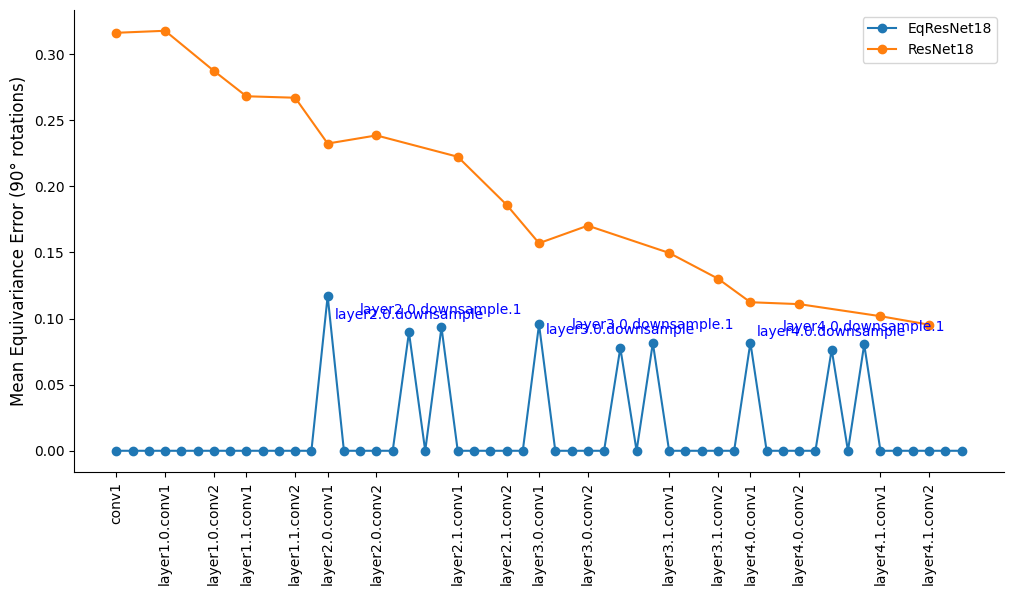

In [27]:
import matplotlib.pyplot as plt

x_ticks = [name for name in eq_n8_gb_layers if 'conv' in name]
print(x_ticks)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(eq_n8_gb_layers, eq_n8_gb_layers_means, label='EqResNet18', marker='o')
ax.plot(resnet_layers, resnet_layers_means, label='ResNet18', marker='o')

# Set x-ticks
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=90) 

# ticks for big error
for name, val in zip(eq_n8_gb_layers, eq_n8_gb_layers_means):
    if val > 0.05 and name not in x_ticks:
        ax.annotate(name, (name, val), textcoords="offset points", xytext=(0,10), ha='center', color='blue')


ax.legend()
ax.set_ylabel('Mean Equivariance Error (90° rotations)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [43]:
eq_n8_layers

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.downsample',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer3.0.conv1',
 'layer3.0.bn1',
 'layer3.0.relu',
 'layer3.0.conv2',
 'layer3.0.bn2',
 'layer3.0.downsample',
 'layer3.1.conv1',
 'layer3.1.bn1',
 'layer3.1.relu',
 'layer3.1.conv2',
 'layer3.1.bn2',
 'layer4.0.conv1',
 'layer4.0.bn1',
 'layer4.0.relu',
 'layer4.0.conv2',
 'layer4.0.bn2',
 'layer4.0.downsample',
 'layer4.1.conv1',
 'layer4.1.bn1',
 'layer4.1.relu',
 'layer4.1.conv2',
 'layer4.1.bn2',
 'gpool']

# Rotation invariance

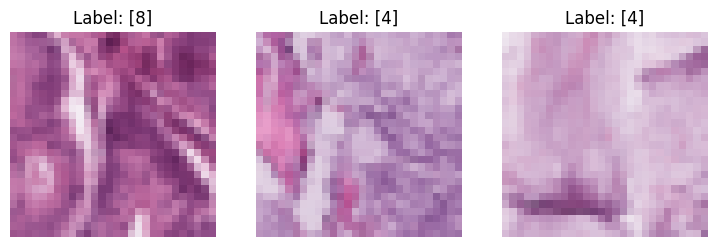

In [ ]:
import random
import matplotlib.pyplot as plt

rand_idx = [random.randint(0, len(pmnist_test)-1) for _ in range(3)]
rand_idx = [0,1,2]
X_samples = [pmnist_test[i][0].cpu().numpy() for i in rand_idx]
y_samples = [pmnist_test[i][1] for i in rand_idx]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i in range(3):
    img, label = X_samples[i], y_samples[i]

    img_rgb = img.transpose(1, 2, 0)  
    axes[i].imshow(img_rgb)
    
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()


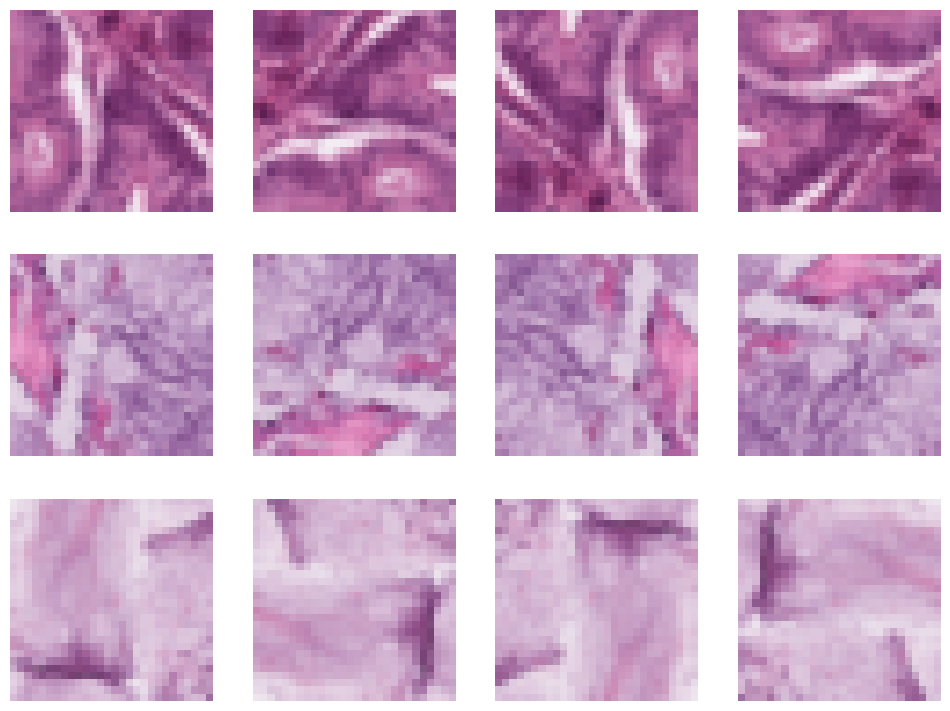

In [ ]:
# Rotations of samples
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

rotated_samples = {}  # store all rotations

for i, img in enumerate(X_samples):
    rotated_samples[i] = {}  # list to store all rotations
    for k in range(4):
        # rotate along H and W axes (axes 1 and 2)
        rot_img = np.rot90(img, k, axes=(1, 2))
        # transpose to HWC for imshow
        rot_img_HWC = rot_img.transpose(1, 2, 0)
        rotated_samples[i][k] = rot_img_HWC
        
        axes[i, k].imshow(rot_img_HWC)  # show the transposed image
        axes[i, k].axis('off')

In [12]:
# SimCLR
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_resnet18)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_resnet18)

acc_simclr, classifier_simclr = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8520891364902506


In [9]:
# EqCLR
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq)

acc_eqclr, classifier_eqclr = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8277158774373259


In [14]:
# EqCLR N=8
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq_n8)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq_n8)

acc_eqclr_n8, classifier_eqclr_n8 = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8537604456824512


In [15]:
# SimCLR without rotation
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_resnet18_wo_rotation)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_resnet18_wo_rotation)

acc_simclr_wo_rotation, classifier_simclr_wo_rotation = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.866991643454039


In [16]:
# EqCLR with rotation
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq_w_rotation)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq_w_rotation)

acc_eqclr_w_rotation, classifier_eqclr_w_rotation = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8296657381615599


In [14]:
# wide resnet
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_w_res)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_w_res)

acc_w_res, classifier_w_res = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8857938718662952


In [ ]:
for keys in rotated_samples.keys():
    samples = rotated_samples[keys]
    print(f"------------------ Sample {keys} ------------------")
    for rot in samples.keys():
        img = rotated_samples[keys][rot]
        img_tensor = torch.tensor(img.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device)  # convert to tensor and add batch dimension
        
        # SimCLR
        #print(f"--------- SimCLR --------")
        with torch.no_grad():
            h, _ = model_resnet18(img_tensor)
        #z_np = h.to(device)
        y_pred = classifier_simclr(h)
        print(f"SimCLR - Predicted label: {y_pred.argmax()} -- True label: {y_samples[keys]}")

        # EqCLR
        #print(f"--------- EqCLR --------")
        with torch.no_grad():
            h_eq, _ = model_eq(img_tensor)
        # z_eq_np = h_eq.to(device)
        y_pred_eq = classifier_eqclr(h_eq)
        print(f"EqCLR -Predicted label: {y_pred_eq.argmax()} -- True label: {y_samples[keys]}")

------------------ Sample 0 ------------------
SimCLR - Predicted label: 7 -- True label: [8]
EqCLR -Predicted label: 8 -- True label: [8]
SimCLR - Predicted label: 2 -- True label: [8]
EqCLR -Predicted label: 2 -- True label: [8]
SimCLR - Predicted label: 7 -- True label: [8]
EqCLR -Predicted label: 7 -- True label: [8]
SimCLR - Predicted label: 7 -- True label: [8]
EqCLR -Predicted label: 7 -- True label: [8]
------------------ Sample 1 ------------------
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 8 -- True label: [4]
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 8 -- True label: [4]
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 2 -- True label: [4]
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 2 -- True label: [4]
------------------ Sample 2 ------------------
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 5 -- True label: [4]
SimCLR - Predicted label: 7 -- 

In [10]:
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import random

models = {
    #"eqResnet18_N8": (model_eq_n8, classifier_eqclr_n8),
    "EqResnet18": (model_eq, classifier_eqclr),
    # "EqResnet18 with rotation": (model_eq_w_rotation, classifier_eqclr_w_rotation),
    # "Resnet18": (model_resnet18, classifier_simclr),
    # "Resnet18 without rotation": (model_resnet18_wo_rotation, classifier_simclr_wo_rotation),
}
accuracies = {}

for model_name in models:
    model, classifier = models[model_name]
    accuracies[model_name] = {}

    with torch.no_grad():
        yhat = []
        y = []
        for batch_idx, batch in enumerate(DataLoader(pmnist_test, batch_size=1024)):
            images, labels = batch

            rotated_images = []
            for img in images:
                angle = random.choice([0, 90, 180, 270])
                img_rot = TF.rotate(img, angle, interpolation=InterpolationMode.NEAREST, expand=False)
                rotated_images.append(img_rot)

            rotated_images = torch.stack(rotated_images)

            h, z = model(rotated_images.to(device))
            logits = classifier(h)

            yhat.append(logits.cpu().numpy())
            y.append(labels.cpu().numpy().ravel())

        yhat = np.vstack(yhat)
        y = np.hstack(y)

    acc = (yhat.argmax(axis=1) == y).mean()
    accuracies[model_name]['Lin. acc. rotated data'] = acc
    print(f"Linear accuracy for {model_name}: {acc}", flush=True)


Linear accuracy for EqResnet18: 0.8229805013927577


In [11]:
import pandas as pd

accuracies['eqResnet18_N8']['Lin. acc. original data'] = acc_eqclr_n8
accuracies['EqResnet18']['Lin. acc. original data'] = acc_eqclr
accuracies['EqResnet18 with rotation']['Lin. acc. original data'] = acc_eqclr_w_rotation
accuracies['Resnet18']['Lin. acc. original data'] = acc_simclr
accuracies['Resnet18 without rotation']['Lin. acc. original data'] = acc_simclr_wo_rotation
accuracies_df = pd.DataFrame(accuracies).T
display(accuracies_df)

NameError: name 'acc_eqclr_n8' is not defined

In [18]:
def rotate_90(x, angle):
    """Rotate a BCHW PyTorch tensor by 0/90/180/270 degrees without interpolation."""
    if angle == 0:
        return x
    elif angle == 90:
        return x.transpose(-1, -2).flip(-1)        # rotate 90° CCW
    elif angle == 180:
        return x.flip(-1).flip(-2)
    elif angle == 270:
        return x.transpose(-1, -2).flip(-2)        # rotate 90° CW
    else:
        raise ValueError("Angle must be 0, 90, 180, or 270")


In [16]:
import torchvision.transforms.functional as TF
import tensorflow as tf

models = {
    #"eqResnet18_N8": (model_eq_n8, classifier_eqclr_n8),
    #"EqResnet18": (model_eq, classifier_eqclr),
    "WideResnet18": (model_w_res, classifier_w_res),
    # "EqResnet18 with rotation": (model_eq_w_rotation, classifier_eqclr_w_rotation),
    # "Resnet18": (model_resnet18, classifier_simclr),
    # "Resnet18 without rotation": (model_resnet18_wo_rotation, classifier_simclr_wo_rotation),
}
consistencies = {}

for model_name in models:
    model, classifier = models[model_name]
    consistencies[model_name] = {}
    
    with torch.no_grad():
        y_hat = []
        y = []
        for angle in [0, 90, 180, 270]:
            yhat_angle = []
            y_angle = []
            for batch_idx, batch in enumerate(DataLoader(pmnist_test, batch_size=1024)):
                images, labels = batch

                rotated_images = []
                for img in images:
                    img_rot = TF.rotate(img, angle, expand=False)
                    # img_rot = rotate_90(img, angle)
                    rotated_images.append(img_rot)

                rotated_images = torch.stack(rotated_images)

                h, z = model(rotated_images.to(device))
                logits = classifier(h)

                yhat_angle.append(logits.cpu().numpy())
                y_angle.append(labels.cpu().numpy().ravel())

            yhat_angle = np.vstack(yhat_angle)
            y_angle = np.hstack(y_angle)

            y_hat.append(yhat_angle.argmax(axis=1))
            y = y_angle

        acc = (yhat_angle.argmax(axis=1) == y_angle).mean()
        #accuracies[model_name]['Lin. acc. rotated data'] = acc
        print(f"Linear accuracy for {model_name} - rotation {angle}: {acc}", flush=True)

        # # compute consistency
        # consistent_mask = (y_hat[0] == y_hat[1]) & \
        #               (y_hat[0] == y_hat[2]) & \
        #               (y_hat[0] == y_hat[3])

        # consistency_percentage = consistent_mask.mean() * 100
        # print(f"Percentage of samples predicted the same across all rotations: {consistency_percentage:.2f}%")
            
        y_hat = np.vstack(y_hat).T  # shape (n_samples, 4)
        num_unique_preds = np.array([len(np.unique(p)) for p in y_hat])

        # Now compute percentages
        total_samples = len(num_unique_preds)
        percentages = {
            'all_same': (num_unique_preds == 1).sum() / total_samples * 100,
            '1 different': (num_unique_preds == 2).sum() / total_samples * 100,
            '2 different': (num_unique_preds == 3).sum() / total_samples * 100,
            'all different': (num_unique_preds == 4).sum() / total_samples * 100
        }
        consistencies[model_name] = percentages

        # Print nicely
        for k, v in percentages.items():
            print(f"{k}: {v:.2f}%")

Linear accuracy for WideResnet18 - rotation 270: 0.8881615598885794
all_same: 93.72%
1 different: 6.10%
2 different: 0.18%
all different: 0.00%


In [17]:
import pandas as pd

consistencies_df = pd.DataFrame(consistencies).T
display(consistencies_df)

,all_same,1 different,2 different,all different
WideResnet18,93.718663,6.100279,0.181058,0.0


# t-SNE

In [21]:
list_h_eq = []
list_h_res = []
labels_list = []

test_loader = DataLoader(pmnist_test, batch_size=128, shuffle=False)


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        h_eq, _ = model_eq_n8(images)
        h_res, _ = model_resnet18(images) 

        list_h_eq.append(h_eq.cpu())
        list_h_res.append(h_res.cpu())
        labels_list.append(labels)

all_h_eq = torch.cat(list_h_eq, dim=0).numpy()
all_h_res = torch.cat(list_h_res, dim=0).numpy()
all_labels = torch.cat(labels_list, dim=0).numpy()

In [22]:
from openTSNE import TSNE

tsne_eq = TSNE()
eq_emb = tsne_eq.fit(all_h_eq)

tsne_res = TSNE()
res_emb = tsne_res.fit(all_h_res)

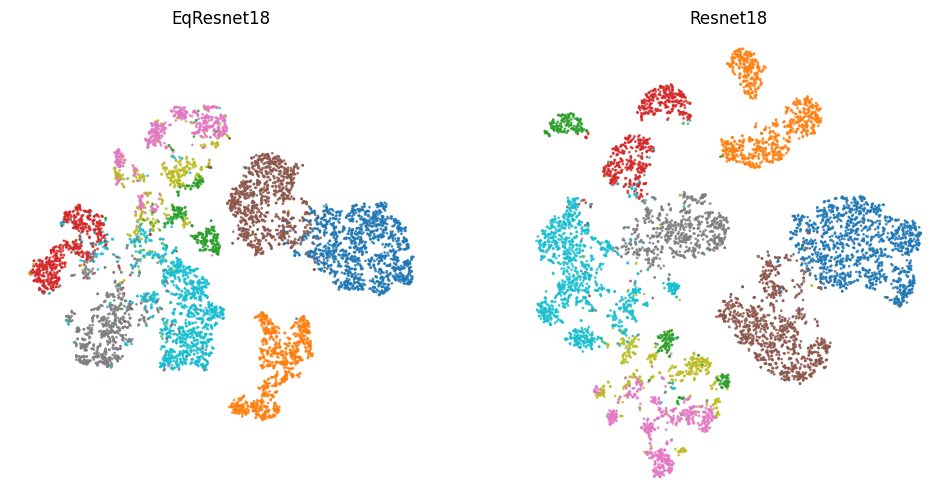

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# EqCLR plot
scatter_eq = ax[0].scatter(eq_emb[:, 0], eq_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[0].set_title('EqResnet18')

# SimCLR plot
scatter_res = ax[1].scatter(res_emb[:, 0], res_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[1].set_title('Resnet18')

for a in ax:
    a.axis('off')
    a.axis('equal')
